# Importing relevant libraries

In [3]:
import numpy as np
import pandas as pd
import json
import requests
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
import folium
import matplotlib.pyplot as plt
import seaborn as sns

# Loading data for each district

In [5]:
data = pd.DataFrame({'name':['Kazimierz','Main square'],
                     'latitude':[50.050186,50.061731],
                     'longitude':[19.945066,19.938071]})
data

,name,latitude,longitude
0,Kazimierz,50.050186,19.945066
1,Main square,50.061731,19.938071


# Creating folium map of Cracow

In [8]:
map_cracow = folium.Map(location = [50.0554,19.9383], zoom_start=14.4)

for lat,long,name in zip(data['latitude'],data['longitude'],data['name']):
    folium.Marker(
        [lat,long],
        popup = name).add_to(map_cracow)
map_cracow

In [4]:
CLIENT_ID = '-' 
CLIENT_SECRET = '-' 
VERSION = '-' 
LIMIT = 100

# Function for aquaring data through explore endpoint of Foursquare API

In [5]:
def getVanues(names, latitudes,longtitudes,RADIUS=400):
    
    venues_list=[]
    
    for name,lat,lng in zip(names,latitudes,longtitudes):
        print(name)
        
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng, 
            VERSION, 
            RADIUS, 
            LIMIT)
        
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(
            name,
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    venues = pd.DataFrame([item for venues_list in venues_list for item in venues_list])
    venues.columns = ['District','id','Venues','Venue Latitude', 'Venue Longitude', 'Venue Category']
    return(venues)

In [6]:
venues = getVanues(names=data['name'],
                   latitudes=data['latitude'],
                   longtitudes=data['longitude'])

Kazimierz
Main square


# DataFrame with local venues

In [7]:
venues

,District,id,Venues,Venue Latitude,Venue Longitude,Venue Category
0,Kazimierz,56193c32498e5b08a853b2e6,Youmiko Sushi,50.050314,19.943130,Sushi Restaurant
1,Kazimierz,55ce5da3498e5b80f82f9afc,BARaWINO,50.048434,19.944891,Wine Bar
2,Kazimierz,5639c271cd1086837a2fea42,Nolio,50.049356,19.942901,Pizza Place
3,Kazimierz,5283cd6411d296aa84e3d8d7,Bottiglieria 1881,50.048738,19.946163,Italian Restaurant
4,Kazimierz,57262e7c498e0c9c72558bb5,Good Lood,50.048777,19.944739,Ice Cream Shop
...,...,...,...,...,...,...
195,Main square,55448431498e731178b9e24b,Little Havana Hostel,50.061960,19.934831,Hostel
196,Main square,4fb68199e4b0204f4d42f2e0,Muzeum Farmacji,50.063268,19.940134,History Museum
197,Main square,4cdda698db1254810bab2bce,CK Dezerter,50.060336,19.936326,Eastern European Restaurant
198,Main square,51802019498ef82bbe68129f,Tiffany Ice cream,50.063795,19.935643,Ice Cream Shop


In [8]:
venues.columns

Index(['District', 'id', 'Venues', 'Venue Latitude', 'Venue Longitude',
       'Venue Category'],
      dtype='object')

# Function for aquaring data through details endpoint of Foursquare API

In [9]:
def getVanues_details(venue_list):
    
    venues_list_details = []
    
    
    for venue_id in venue_list:
    
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
            venue_id, 
            CLIENT_ID, 
            CLIENT_SECRET,
            VERSION)
        
        results_list = []
        results = requests.get(url).json()['response']['venue']
        results_list.append(results)
        
        venues_list_details.append([(
            venue_id,
            v['verified'],
            v['rating'],
            v['tips']['count'],
            v['likes']['count'],
            v['photos']['count']) for v in results_list])
        
    venues_details = pd.DataFrame([item for venues_list_details in venues_list_details for item in venues_list_details])
    venues_details.columns = ['id','Verified', 'Rating', 'Tips Count','Likes Count','Photos Count']
    return(venues_details)

In [10]:
venues_details = getVanues_details(venues['id'])

# DataFrame with local venues details

In [11]:
venues_details

,id,Verified,Rating,Tips Count,Likes Count,Photos Count
0,56193c32498e5b08a853b2e6,False,9.5,89,237,102
1,55ce5da3498e5b80f82f9afc,False,9.2,13,67,21
2,5639c271cd1086837a2fea42,False,9.0,77,251,50
3,5283cd6411d296aa84e3d8d7,False,8.7,5,22,11
4,57262e7c498e0c9c72558bb5,False,8.6,34,109,38
...,...,...,...,...,...,...
195,55448431498e731178b9e24b,False,7.6,3,10,6
196,4fb68199e4b0204f4d42f2e0,False,7.5,1,8,7
197,4cdda698db1254810bab2bce,False,7.4,6,26,28
198,51802019498ef82bbe68129f,False,7.8,23,50,30


# Merging both DataFrames

In [12]:
venues = venues.merge(venues_details, on='id')

In [13]:
venues

,District,id,Venues,Venue Latitude,Venue Longitude,Venue Category,Verified,Rating,Tips Count,Likes Count,Photos Count
0,Kazimierz,56193c32498e5b08a853b2e6,Youmiko Sushi,50.050314,19.943130,Sushi Restaurant,False,9.5,89,237,102
1,Kazimierz,55ce5da3498e5b80f82f9afc,BARaWINO,50.048434,19.944891,Wine Bar,False,9.2,13,67,21
2,Kazimierz,5639c271cd1086837a2fea42,Nolio,50.049356,19.942901,Pizza Place,False,9.0,77,251,50
3,Kazimierz,5283cd6411d296aa84e3d8d7,Bottiglieria 1881,50.048738,19.946163,Italian Restaurant,False,8.7,5,22,11
4,Kazimierz,57262e7c498e0c9c72558bb5,Good Lood,50.048777,19.944739,Ice Cream Shop,False,8.6,34,109,38
...,...,...,...,...,...,...,...,...,...,...,...
195,Main square,55448431498e731178b9e24b,Little Havana Hostel,50.061960,19.934831,Hostel,False,7.6,3,10,6
196,Main square,4fb68199e4b0204f4d42f2e0,Muzeum Farmacji,50.063268,19.940134,History Museum,False,7.5,1,8,7
197,Main square,4cdda698db1254810bab2bce,CK Dezerter,50.060336,19.936326,Eastern European Restaurant,False,7.4,6,26,28
198,Main square,51802019498ef82bbe68129f,Tiffany Ice cream,50.063795,19.935643,Ice Cream Shop,False,7.8,23,50,30


# Performing groupby() operation, and counting most popular categories od venues in each district

In [14]:
venues_kazimierz = venues[venues['District'] == 'Kazimierz']
venues_kazimierz_count = pd.DataFrame(venues_kazimierz.groupby(['Venue Category','District'])['Venue Category'].count())
venues_kazimierz_count.columns = ['Count']
venues_kazimierz_count.reset_index(level=venues_kazimierz_count.index.names, inplace=True)
venues_kazimierz_count = venues_kazimierz_count.drop(['District'], axis = 1)
venues_kazimierz_count.set_index(venues_kazimierz_count['Venue Category'], inplace = True)
venues_kazimierz_count = venues_kazimierz_count[venues_kazimierz_count['Count'] > 3]
venues_kazimierz_count.drop(['Venue Category'], axis = 1)

,Count
Venue Category,
Bar,5
Café,10
Food Truck,6
Polish Restaurant,5
Restaurant,6


In [15]:
venues_main_square = venues[venues['District'] == 'Main square']
venues_main_square_count = pd.DataFrame(venues_main_square.groupby(['Venue Category','District'])['Venue Category'].count())
venues_main_square_count.columns = ['Count']
venues_main_square_count.reset_index(level=venues_main_square_count.index.names, inplace=True)
venues_main_square_count = venues_main_square_count.drop(['District'], axis = 1)
venues_main_square_count.set_index(venues_main_square_count['Venue Category'], inplace = True)
venues_main_square_count = venues_main_square_count[venues_main_square_count['Count'] > 3]
venues_main_square_count.drop(['Venue Category'], axis = 1)

,Count
Venue Category,
Café,10
Coffee Shop,4
Ice Cream Shop,4
Italian Restaurant,7
Plaza,5
Polish Restaurant,6
Pub,4
Restaurant,4


# Ploting most popular categories od venues in each district

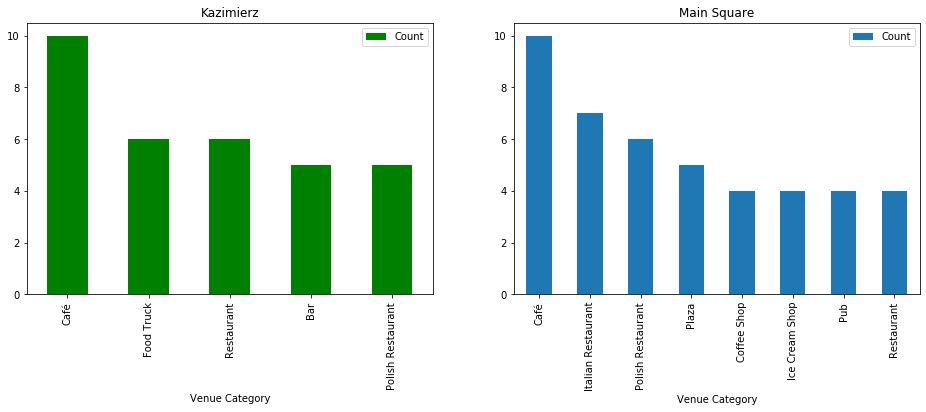

In [16]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,5))
venues_kazimierz_count.sort_values('Count',ascending=False).plot(kind = 'bar', ax=ax1, color='green')
ax1.title.set_text("Kazimierz")
venues_main_square_count.sort_values('Count',ascending=False).plot(kind = 'bar', ax=ax2)
ax2.title.set_text("Main Square")

# Performing descriptive statistics

In [35]:
venues_kazimierz.describe()

,Venue Latitude,Venue Longitude,Rating,Tips Count,Likes Count,Photos Count
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000
mean,50.050685,19.945580,8.037000,27.730000,81.630000,53.21000
std,0.001646,0.002124,0.554441,37.447298,111.967136,68.33892
min,50.047327,19.940641,6.900000,0.000000,6.000000,0.00000
25%,50.049296,19.944371,7.600000,5.750000,16.750000,13.00000
50%,50.050824,19.945645,8.100000,14.500000,44.500000,27.50000
75%,50.051822,19.947206,8.400000,32.250000,78.500000,63.25000
max,50.053440,19.950407,9.500000,213.000000,700.000000,404.00000


In [106]:
venues_main_square.describe()

,Venue Latitude,Venue Longitude,Rating,Tips Count,Likes Count,Photos Count
count,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000
mean,50.061892,19.938012,8.068000,40.09000,134.140000,158.400000
std,0.001325,0.002168,0.434818,57.52612,231.843252,564.601782
min,50.059121,19.933834,7.400000,0.00000,3.000000,2.000000
25%,50.060873,19.936209,7.700000,6.00000,21.250000,20.750000
50%,50.061893,19.938046,8.000000,17.00000,52.000000,49.000000
75%,50.063055,19.939716,8.300000,50.25000,159.250000,117.000000
max,50.064213,19.942660,9.200000,365.00000,1742.000000,5546.000000


# Creating regplots for each each of the combination of target and independent feature, to see if there is a visible linear correlations 

Text(0.5, 1.0, 'Kazimierz')

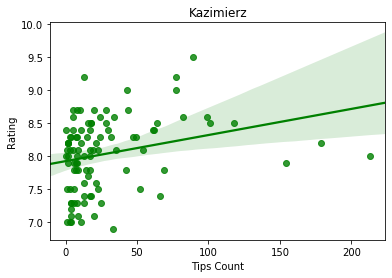

In [37]:
ax = sns.regplot(x='Tips Count', y='Rating', data=venues_kazimierz, color='green')
ax.set_title('Kazimierz')

Text(0.5, 1.0, 'Kazimierz')

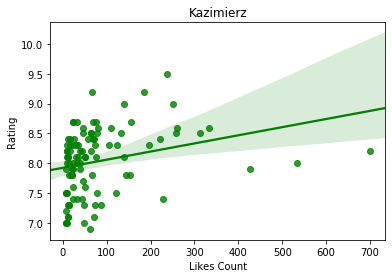

In [38]:
ax = sns.regplot(x='Likes Count', y='Rating', data=venues_kazimierz, color='green')
ax.set_title('Kazimierz')

Text(0.5, 1.0, 'Kazimierz')

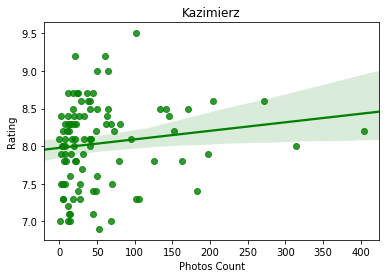

In [39]:
ax = sns.regplot(x='Photos Count', y='Rating', data=venues_kazimierz, color='green')
ax.set_title('Kazimierz')

Text(0.5, 1.0, 'Main square')

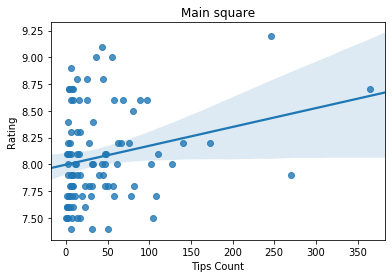

In [42]:
ax = sns.regplot(x='Tips Count', y='Rating', data=venues_main_square)
ax.set_title('Main square')

Text(0.5, 1.0, 'Main square')

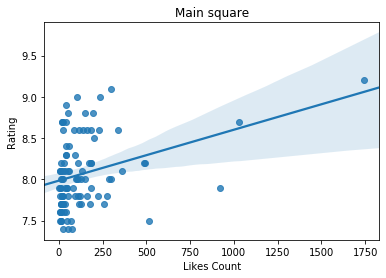

In [43]:
ax = sns.regplot(x='Likes Count', y='Rating', data=venues_main_square)
ax.set_title('Main square')

Text(0.5, 1.0, 'Main square')

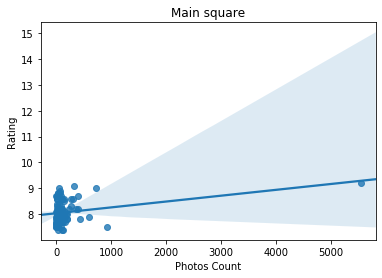

In [44]:
ax = sns.regplot(x='Photos Count', y='Rating', data=venues_main_square)
ax.set_title('Main square')

# Fitting and evaluating one comibnation of target and feature

In [45]:
cdf = venues_kazimierz[['Rating','Tips Count']]

In [47]:
msk = np.random.rand(len(venues_kazimierz)) < 0.8
train = cdf[msk]
test = cdf[~msk]

In [52]:
reg = linear_model.LinearRegression()
train_x = np.asanyarray(train[['Tips Count']])
train_y = np.asanyarray(train[['Rating']])
reg.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [56]:
test_x = np.asanyarray(test[['Tips Count']])5
test_y = np.asanyarray(test[['Rating']])
test_yhat = reg.predict(test_x)

In [57]:
r2_score(test_yhat,test_y)

-6.821236352451204

# Transforming feature through polunomial transformation, and evaluating model

In [129]:
def get_poly_degress(degrees):
    
    r2_score_dict = {}
    
    for d in degrees:
        poly = PolynomialFeatures(degree=d)
        train_x_poly = poly.fit_transform(train_x)
        reg_poly = linear_model.LinearRegression()
        reg_poly.fit(train_x_poly, train_y)
        test_x_poly = poly.fit_transform(test_x)
        test_yhat_poly = reg_poly.predict(test_x_poly)
        r2 = r2_score(test_yhat_poly, test_y)
        r2_score_dict.update({d:r2})
        
    return r2_score_dict

In [124]:
degrees = [2,3,4,5,6,7]
poly_degress = get_poly_degress(degrees)

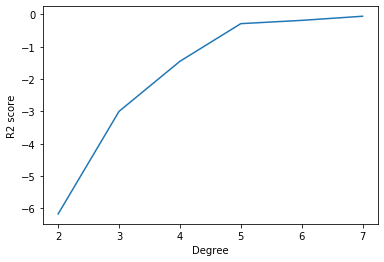

In [136]:
plt.plot(*zip(*sorted(poly_degress.items())))
plt.xlabel("Degree")
plt.ylabel("R2 score")
plt.show()